## 具有神经网络思维的Logistic回归

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from lr_utils import load_dataset

In [3]:
train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = load_dataset()

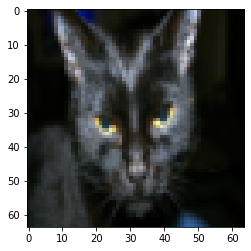

In [4]:
index = 25
plt.imshow(train_set_x_orig[index])

In [5]:
m_train = train_set_y.shape[1] #训练集里图片的数量。
m_test = test_set_y.shape[1] #测试集里图片的数量。
num_px = train_set_x_orig.shape[1] #训练、测试集里面的图片的宽度和高度（均为64x64）。

#现在看一看我们加载的东西的具体情况
print ("训练集的数量: m_train = " + str(m_train))
print ("测试集的数量 : m_test = " + str(m_test))
print ("每张图片的宽/高 : num_px = " + str(num_px))
print ("每张图片的大小 : (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("训练集_图片的维数 : " + str(train_set_x_orig.shape))
print ("训练集_标签的维数 : " + str(train_set_y.shape))
print ("测试集_图片的维数: " + str(test_set_x_orig.shape))
print ("测试集_标签的维数: " + str(test_set_y.shape))

训练集的数量: m_train = 209
测试集的数量 : m_test = 50
每张图片的宽/高 : num_px = 64
每张图片的大小 : (64, 64, 3)
训练集_图片的维数 : (209, 64, 64, 3)
训练集_标签的维数 : (1, 209)
测试集_图片的维数: (50, 64, 64, 3)
测试集_标签的维数: (1, 50)


In [7]:
#X_flatten = X.reshape(X.shape [0]，-1).T ＃X.T是X的转置
#将训练集的维度降低并转置。
train_set_x_flatten  = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
#将测试集的维度降低并转置。
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("训练集降维最后的维度： " + str(train_set_x_flatten.shape))
print ("训练集_标签的维数 : " + str(train_set_y.shape))
print ("测试集降维之后的维度: " + str(test_set_x_flatten.shape))
print ("测试集_标签的维数 : " + str(test_set_y.shape))

训练集降维最后的维度： (12288, 209)
训练集_标签的维数 : (1, 209)
测试集降维之后的维度: (12288, 50)
测试集_标签的维数 : (1, 50)


In [8]:
train_set_x = train_set_x_flatten / 255
test_set_x = test_set_x_flatten / 255

In [9]:
def sigmoid(z):
    """
    参数：
        z  - 任何大小的标量或numpy数组。
    
    返回：
        s  -  sigmoid（z）
    """
    s = 1 / (1 + np.exp(-z))
    return s

def initialize_with_zeros(dim):
    """
        此函数为w创建一个维度为（dim，1）的0向量，并将b初始化为0。
        
        参数：
            dim  - 我们想要的w矢量的大小（或者这种情况下的参数数量）
        
        返回：
            w  - 维度为（dim，1）的初始化向量。
            b  - 初始化的标量（对应于偏差）
    """
    w = np.zeros(shape = (dim,1))
    b = 0
    #使用断言来确保我要的数据是正确的
    assert(w.shape == (dim, 1)) #w的维度是(dim,1)
    assert(isinstance(b, float) or isinstance(b, int)) #b的类型是float或者是int
    return (w , b)

def propagate(w, b, X, Y):
    """
    实现前向和后向传播的成本函数及其梯度。
    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 矩阵类型为（num_px * num_px * 3，训练数量）
        Y  - 真正的“标签”矢量（如果非猫则为0，如果是猫则为1），矩阵维度为(1,训练数据数量)
        注意：数据的堆积是横向的

    返回：
        cost- 逻辑回归的负对数似然成本
        dw  - 相对于w的损失梯度，因此与w相同的形状
        db  - 相对于b的损失梯度，因此与b的形状相同
    """
    m = X.shape[1]
    
    #正向传播
    A = sigmoid(np.dot(w.T,X) + b) #计算激活值，请参考公式2。
    cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A))) #计算成本，请参考公式3和4。
    
    #反向传播
    dw = (1 / m) * np.dot(X, (A - Y).T) #请参考视频中的偏导公式。
    db = (1 / m) * np.sum(A - Y) #请参考视频中的偏导公式。

    #使用断言确保我的数据是正确的
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    #创建一个字典，把dw和db保存起来。
    grads = {
                "dw": dw,
                "db": db
             }
    return (grads , cost)

In [10]:
#测试propagate
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost = 6.000064773192205


In [11]:
def optimize(w , b , X , Y , num_iterations , learning_rate , print_cost = False):
    """
    此函数通过运行梯度下降算法来优化w和b
    
    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 维度为（num_px * num_px * 3，训练数据的数量）的数组。
        Y  - 真正的“标签”矢量（如果非猫则为0，如果是猫则为1），矩阵维度为(1,训练数据的数量)
        num_iterations  - 优化循环的迭代次数
        learning_rate  - 梯度下降更新规则的学习率
        print_cost  - 每100步打印一次损失值
    
    返回：
        params  - 包含权重w和偏差b的字典
        grads  - 包含权重和偏差相对于成本函数的梯度的字典
        成本 - 优化期间计算的所有成本列表，将用于绘制学习曲线。
    
    提示：
    我们需要写下两个步骤并遍历它们：
        1）计算当前参数的成本和梯度，使用propagate（）。
        2）使用w和b的梯度下降法则更新参数。
    """
    costs = []
    for i in range(num_iterations):
        #得到梯度 损失
        grads, cost = propagate(w, b, X, Y)
        #取出相应梯度
        dw = grads["dw"]
        db = grads["db"]
        #更新参数
        w = w - learning_rate * dw
        b = b - learning_rate * db
        #记录成本
        if i % 100 == 0:
            costs.append(cost)
        #打印成本数据
        if (print_cost) and (i % 100 == 0):
            print("迭代的次数: %i ， 误差值： %f" % (i,cost))
        
    params  = {
                "w" : w,
                "b" : b }
    grads = {
            "dw": dw,
            "db": db } 
    return (params , grads , costs)

In [12]:
#测试optimize
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
params , grads , costs = optimize(w , b , X , Y , num_iterations=100 , learning_rate = 0.009 , print_cost = False)
print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828


In [13]:
def predict(w , b , X ):
    """
    使用学习逻辑回归参数logistic （w，b）预测标签是0还是1，
    
    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 维度为（num_px * num_px * 3，训练数据的数量）的数据
    
    返回：
        Y_prediction  - 包含X中所有图片的所有预测【0 | 1】的一个numpy数组（向量）
    
    """
    
    m  = X.shape[1] #图片的数量
    Y_prediction = np.zeros((1,m)) 
    w = w.reshape(X.shape[0],1)
    
    #计预测猫在图片中出现的概率
    A = sigmoid(np.dot(w.T , X) + b)
    for i in range(A.shape[1]):
        #将概率a [0，i]转换为实际预测p [0，i]
        Y_prediction[0,i] = 1 if A[0,i] > 0.5 else 0
    #使用断言
    assert(Y_prediction.shape == (1,m))
    
    return Y_prediction

def model(X_train , Y_train , X_test , Y_test , num_iterations = 2000 , learning_rate = 0.5 , print_cost = False):
    """
    通过调用之前实现的函数来构建逻辑回归模型
    
    参数：
        X_train  - numpy的数组,维度为（num_px * num_px * 3，m_train）的训练集
        Y_train  - numpy的数组,维度为（1，m_train）（矢量）的训练标签集
        X_test   - numpy的数组,维度为（num_px * num_px * 3，m_test）的测试集
        Y_test   - numpy的数组,维度为（1，m_test）的（向量）的测试标签集
        num_iterations  - 表示用于优化参数的迭代次数的超参数
        learning_rate  - 表示optimize（）更新规则中使用的学习速率的超参数
        print_cost  - 设置为true以每100次迭代打印成本
    
    返回：
        d  - 包含有关模型信息的字典。
    """
    w , b = initialize_with_zeros(X_train.shape[0])
    
    parameters , grads , costs = optimize(w , b , X_train , Y_train,num_iterations , learning_rate , print_cost)
    
    #从字典“参数”中检索参数w和b
    w , b = parameters["w"] , parameters["b"]
    
    #预测测试/训练集的例子
    Y_prediction_test = predict(w , b, X_test)
    Y_prediction_train = predict(w , b, X_train)
    
    #打印训练后的准确性
    print("训练集准确性："  , format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100) ,"%")
    print("测试集准确性："  , format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100) ,"%")
    
    d = {
            "costs" : costs,
            "Y_prediction_test" : Y_prediction_test,
            "Y_prediciton_train" : Y_prediction_train,
            "w" : w,
            "b" : b,
            "learning_rate" : learning_rate,
            "num_iterations" : num_iterations }
    return d

In [14]:
#这里加载的是真实的数据，请参见上面的代码部分。
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

迭代的次数: 0 ， 误差值： 0.693147
迭代的次数: 100 ， 误差值： 0.584508
迭代的次数: 200 ， 误差值： 0.466949
迭代的次数: 300 ， 误差值： 0.376007
迭代的次数: 400 ， 误差值： 0.331463
迭代的次数: 500 ， 误差值： 0.303273
迭代的次数: 600 ， 误差值： 0.279880
迭代的次数: 700 ， 误差值： 0.260042
迭代的次数: 800 ， 误差值： 0.242941
迭代的次数: 900 ， 误差值： 0.228004
迭代的次数: 1000 ， 误差值： 0.214820
迭代的次数: 1100 ， 误差值： 0.203078
迭代的次数: 1200 ， 误差值： 0.192544
迭代的次数: 1300 ， 误差值： 0.183033
迭代的次数: 1400 ， 误差值： 0.174399
迭代的次数: 1500 ， 误差值： 0.166521
迭代的次数: 1600 ， 误差值： 0.159305
迭代的次数: 1700 ， 误差值： 0.152667
迭代的次数: 1800 ， 误差值： 0.146542
迭代的次数: 1900 ， 误差值： 0.140872
训练集准确性： 99.04306220095694 %
测试集准确性： 70.0 %


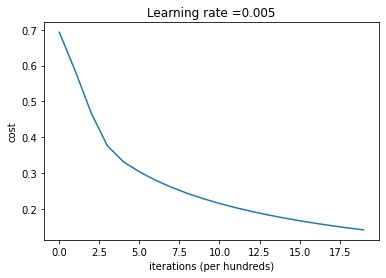

In [15]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

learning rate is: 0.01
训练集准确性： 99.52153110047847 %
测试集准确性： 68.0 %

-------------------------------------------------------

learning rate is: 0.001
训练集准确性： 88.99521531100478 %
测试集准确性： 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
训练集准确性： 68.42105263157895 %
测试集准确性： 36.0 %

-------------------------------------------------------



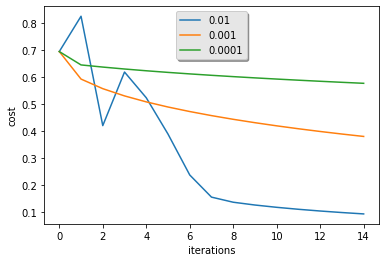

In [16]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

## 神经网络基础

## Week 2 Quiz - Neural Network Basics

1. What does a neuron compute?

   - [ ] A neuron computes an activation function followed by a linear function (z = Wx + b)

   - [x] A neuron computes a linear function (z = Wx + b) followed by an activation function

   - [ ] A neuron computes a function g that scales the input x linearly (Wx + b)

   - [ ] A neuron computes the mean of all features before applying the output to an activation function

   Note: we generally say that the output of a neuron is a = g(Wx + b) where g is the activation function (sigmoid, tanh, ReLU, ...).

2. Which of these is the "Logistic Loss"?

   - Check [here](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression).

   Note: this is the logistic loss you've seen in lecture!

3. Suppose img is a (32,32,3) array, representing a 32x32 image with 3 color channels red, green and blue. How do you reshape this into a column vector?

   - `x = img.reshape((32 * 32 * 3, 1))`

4. Consider the two following random arrays "a" and "b":

   ```
   a = np.random.randn(2, 3) # a.shape = (2, 3)
   b = np.random.randn(2, 1) # b.shape = (2, 1)
   c = a + b
   ```

   What will be the shape of "c"?

   b (column vector) is copied 3 times so that it can be summed to each column of a. Therefore, `c.shape = (2, 3)`.

5. Consider the two following random arrays "a" and "b":

   ```
   a = np.random.randn(4, 3) # a.shape = (4, 3)
   b = np.random.randn(3, 2) # b.shape = (3, 2)
   c = a * b
   ```

   What will be the shape of "c"?

    "*" operator indicates element-wise multiplication. Element-wise multiplication requires same dimension between two matrices. It's going to be an error.

6. Suppose you have n_x input features per example. Recall that X=[x^(1), x^(2)...x^(m)]. What is the dimension of X?

   `(n_x, m)`

7. Recall that `np.dot(a,b)` performs a matrix multiplication on a and b, whereas `a*b` performs an element-wise multiplication.

   Consider the two following random arrays "a" and "b":

   ```
   a = np.random.randn(12288, 150) # a.shape = (12288, 150)
   b = np.random.randn(150, 45) # b.shape = (150, 45)
   c = np.dot(a, b)
   ```

   What is the shape of c?

   `c.shape = (12288, 45)`, this is a simple matrix multiplication example.

8. Consider the following code snippet:

   ```
   # a.shape = (3,4)
   # b.shape = (4,1)
   for i in range(3):
     for j in range(4):
       c[i][j] = a[i][j] + b[j]
   ```

   How do you vectorize this?

   `c = a + b.T`

9. Consider the following code:

   ```
   a = np.random.randn(3, 3)
   b = np.random.randn(3, 1)
   c = a * b
   ```

   What will be c?

   This will invoke broadcasting, so b is copied three times to become (3,3), and ∗ is an element-wise product so `c.shape = (3, 3)`.

10. Consider the following computation graph.

    ```
    J = u + v - w
      = a * b + a * c - (b + c)
      = a * (b + c) - (b + c)
      = (a - 1) * (b + c)
    ```

    Answer: `(a - 1) * (b + c)`